# Machine Learning Pipeline with Proactive Jupyter Kernel and Tensorboard

The purpose of this notebook is to classify a given silhouette as one of four types of vehicle, using a set of features extracted from the silhouette. The vehicle may be viewed from one of many different angles. This object recognition strategy was successfully used to discriminate between silhouettes of model cars, vans and buses viewed from constrained elevation but all angles of rotation. Link address to the original dataset: https://archive.ics.uci.edu/ml/datasets/Statlog+(Vehicle+Silhouettes)

![alt text](images/vehicle_silhouette.png "Title")

#### Dataset description
The features were extracted from the silhouettes by the HIPS (Hierarchical Image Processing System) extension BINATTS, which extracts a combination of scale independent features utilising both classical moments based measures such as scaled variance, skewness and kurtosis about the major/minor axes and heuristic measures such as hollows, circularity, rectangularity and compactness.

Four "Corgie" model vehicles were used for the experiment: a double decker bus, Cheverolet van, Saab 9000 and an Opel Manta 400. This particular combination of vehicles was chosen with the expectation that the bus, van and either one of the cars would be readily distinguishable, but it would be more difficult to distinguish between the cars.

#### Problem statement
The objective is to classify a given silhouette as one of three types of vehicle, using a set of features extracted from the silhouette. The vehicle may be viewed from one of many different angles.

In [ ]:
# The dataset is stored as a CSV file and loaded as a data table.
# Below, we see the first 5 rows of the dataset.

,compactness,circularity,distance_circularity,radius_ratio,pr_axis_aspect_ratio,max_length_aspect_ratio,scatter_ratio,elongatedness,pr_axis_rectangularity,max_length_rectangularity,scaled_variance_major_axis,scaled_variance_minor_axis,scaled_radius_gyration,skewness_major_axis,skewness_minor_axis,kurtosis_minor_axis,kurtosis_major_axis,hollows_ratio,vehicle_class
0,95.0,48.0,83.0,178.0,72.0,10.0,162.0,42.0,20.0,159.0,176.0,379.0,184.0,70.0,6.0,16.0,187.0,197.0,van
1,91.0,41.0,84.0,141.0,57.0,9.0,149.0,45.0,19.0,143.0,170.0,330.0,158.0,72.0,9.0,14.0,189.0,199.0,van
2,104.0,50.0,106.0,209.0,66.0,10.0,207.0,32.0,23.0,158.0,223.0,635.0,220.0,73.0,14.0,9.0,188.0,196.0,saab
3,93.0,41.0,82.0,159.0,63.0,9.0,144.0,46.0,19.0,143.0,160.0,309.0,127.0,63.0,6.0,10.0,199.0,207.0,van
4,85.0,44.0,70.0,205.0,103.0,52.0,149.0,45.0,19.0,144.0,241.0,325.0,188.0,127.0,9.0,11.0,180.0,183.0,bus


* It shows that there are 18 independent variables (compactness, circularity, distance_circularity, radius_ratio, pr.axis_aspect_ratio, max.length_aspect_ratio, scatter_ratio, elongatedness, pr.axis_rectangularity, max.length_rectangularity, scaled_variance, scaled_variance.1, scaled_radius_of_gyration, scaled_radius_of_gyration.1, skewness_about, skewness_about.1, skewness_about.2, hollows_ratio) and one dependent variable (vehicle_class).

* Only the class variable is non numeric others are numeric.

---

## Proposed solution

To find the best machine learning model for the above dataset, we will use Cross-Validation and Hyperparameter optimization for model selection. This approach is also named Nested Cross-Validation.

Cross-Validation also referred to as out of sampling technique is an essential element of a data science project. It is a resampling procedure used to evaluate machine learning models and access how the model will perform for an independent test dataset.

Hyperparameter optimization or tuning is a process of choosing a set of hyperparameters for a machine learning algorithm that performs best for a particular dataset.

Model selection without nested cross-validation uses the same data to tune model parameters and evaluate model performance that may lead to an optimistically biased evaluation of the model. We get a poor estimation of errors in training or test data due to information leakage. To overcome this problem, Nested Cross-Validation comes into the picture.

---

## Let's create a Machine Learning Pipeline with the Proactive Jupyter Kernel

The ActiveEon Jupyter Kernel adds a kernel backend to Jupyter.

This kernel interfaces directly with the ProActive scheduler and constructs tasks and workflows to execute them on the fly.

With this interface, users can run their code locally and test it using a native python kernel, and by a simple switch to ProActive kernel, run it on remote public or private infrastructures without having to modify the code.

See https://github.com/ow2-proactive/proactive-jupyter-kernel for more information.

As a quick start, we recommend the user to run the `#%help()` pragma using the following script:

In [1]:
#%help()


#%connect(): connects to an ActiveEon server
#%import(): import specified libraries to all tasks of a same script language
#%configure(): configures the ProActive kernel's behavior
#%task(): creates/modifies a task
#%delete_task(): removes a task from the workflow
#%pre_script(): sets the pre-script of a task
#%post_script(): sets the post-script of a task
#%selection_script(): sets the selection script of a task
#%job_selection_script(): sets the default selection script of a job
#%fork_env(): sets the fork environment script
#%job_fork_env(): sets the default fork environment of a job
#%runtime_env(): sets the default runtime environment of a job
#%split(): creates/modifies a splitting task of a replicate control
#%runs(): creates/modifies the configuration script of a replicate control
#%process(): creates/modifies the script of a replicated processing task
#%merge(): creates/modifies a merging task of a replicate control
#%start(): creates/modifies a start task of a loop control
#

## 1. Connection

The first step is to connect to the ProActive scheduler.

If you are trying ProActive for the first time, sign up on the [try platform](https://try.activeeon.com/signup.html).

Once you receive your login and password, connect to the trial platform using the `#%connect()` pragma.

For more information, type: `#%help(pragma=connect)`

In [2]:
#%connect(url=https://try.activeeon.com:8443)

Login:  admin
Password:  ············


Connecting to server ...
Connected as 'admin'!


## 2. Runtime environment definition

For this notebook, we will use a docker image, named [activeeon/dlm3](https://hub.docker.com/r/activeeon/dlm3/), with all software stack (machine learning frameworks, libraries and toolkits) to ensure a consistent environment for execution. Docker images are portable as it encapsulates everything that is required to run an application.

The `#%runtime_env()` pragma enable user to define the runtime environment for pipeline execution.

The user can select the container type (docker, podman, singularity), the container image, and mount local directories inside container.

For more information, type: `#%help(pragma=runtime_env)`

In [3]:
#%runtime_env(type=docker,image=activeeon/dlm3,mount_host_path=/shared,mount_container_path=/shared,debug=false,verbose=false,force=off)

Saving the runtime environment ...
Done.


## 3. Importing libraries

Now, let's import all packages needed to run the notebook.

The main difference between the ProActive and 'native language' kernels resides in the way the memory is accessed
during blocks execution. In a common native language kernel, the whole script code (all the notebook blocks) is
locally executed in the same shared memory space; whereas the ProActive kernel will execute each created task in an
independent process. In order to facilitate the transition from native language to ProActive kernels, we included the
pragma `#%import()`. This pragma gives the user the ability to add libraries that are common to all created tasks, and
thus relative distributed processes, that are implemented in the same native script language.

The import pragma is used as follows:

`#%import([language=SCRIPT_LANGUAGE])`.

Example:

```python
#%import(language=Python)
import os
import pandas
```

NOTE: If the language is not specified, Python is considered as default language.

In [4]:
#%import()
import json
import numpy as np
import pandas as pd
import pickle
import bz2
import random

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold
from scipy.stats import uniform

from tensorboardX import SummaryWriter
from pathlib import Path

Saving 'Python' imports ...
Saved.


## 4. Creating tasks

### 4.1 Creating the _import_data_ task

This task is used to load the dataset and transfer to the next task to train a machine learning algorithm using nested cross validation.

In [5]:
#%task(name=import_data,export=[dataframe_json])
dataset_url = "https://activeeon-public.s3.eu-west-2.amazonaws.com/datasets/vehicle_silhouette_weka_dataset.csv"
dataframe = pd.read_csv(dataset_url)

dataframe_json = dataframe.to_json(orient='split').encode()
compressed_data = bz2.compress(dataframe_json

Creating a proactive 'Python' task ...
Task 'import_data' created.
Adding default selection script to the proactive task ...
Adding job fork environment to the proactive task ...
Adding exporting variables script ...
Adding 'Python' library imports ...
Done.


### 4.2 Creating the _nested_cross_validation_ task 

Nested Cross-Validation (Nested-CV) nests cross-validation and hyperparameter tuning. It is used to evaluate the performance of a machine learning algorithm and also estimates the generalization error of the underlying model and its hyperparameter search.

Both Cross-Validation and Hyperparameter Optimization is an important aspect of a data science project. Cross-validation is used to evaluate the performance of a machine learning algorithm and Hyperparameter tuning is used to find the best set of hyperparameters for that machine learning algorithm.

The Nested-CV has an inner loop CV nested in an outer CV. The inner loop is responsible for model selection/hyperparameter tuning (similar to validation set), while the outer loop is for error estimation (test set).

![alt text](images/nested_cv.png "Title")

In this notebook, we will run 3 simulations (**runs=3 in the #%task pragma**) of Nested-CV using the Logistic Regression algorithm. 

For each Nested-CV simulation, we have:
* The outer loop is repeated 10 times(n_splits = 10 for outer_cv), generating ten different test sets. 
* For each iteration, the outer train set will be further split (in this case, into 10 folds).
* If there are 10 outer folds and 10 inner folds, as in the picture, the total number of trained models will be 100.

In total, we will run 3 simulations, where each simulation will create 100 models.

In [6]:
#%task(name=nested_cross_validation,dep=[import_data],import=[dataframe_json],export=[nested_scores_json],runs=3)
dataframe = pd.read_json(dataframe_json, orient='split')

label_column = "vehicle_class"
dataframe_train = dataframe.drop(label_column, axis=1, inplace=False)
dataframe_label = dataframe[label_column]

# Set up possible values of parameters to optimize over
distributions = dict(C=uniform(loc=0, scale=4), penalty=['l2', 'l1'])

# We will use a Logistic Classifier with "rbf" kernel
# logistic = LogisticRegression(solver='saga', tol=1e-2, max_iter=200, random_state=random.randint(0,9))
logistic = LogisticRegression(solver='saga', tol=1e-2, max_iter=200, random_state=random.randint(0,9))

# Choose cross-validation techniques for the inner and outer loops,
# independently of the dataset.
# E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
inner_cv = KFold(n_splits=10, shuffle=True, random_state=random.randint(0,9))
outer_cv = KFold(n_splits=10, shuffle=True, random_state=random.randint(0,9))

# Non_nested parameter search and scoring
# The Scikit-learn package provides comes with GridSearchCV and RandomSearchCV implementation.
# These searching techniques return the best machine learning model by tuning the given parameters.
# The inner-CV is applied to the (k-1) folds or groups dataset from the outer CV. 
# The set of parameters are optimized using RandomSearchCV and is then used to configure the model.
# The best model returned from RandomSearchCV (or GridSearchCV) is then evaluated using the last fold or group.
# This method is repeated k times (k=10 for this example), and the final CV score is computed by taking the mean of all k scores.
clf = RandomizedSearchCV(estimator=logistic, param_distributions=distributions, cv=inner_cv)
clf.fit(dataframe_train, dataframe_label)

# Nested CV with parameter optimization
nested_scores = cross_val_score(clf, X=dataframe_train, y=dataframe_label, cv=outer_cv)

# Save scores on Tensorboard
if 'variables' in globals():
    PA_JOB_ID = variables.get("PA_JOB_ID")
    PA_TRIAL_ID = variables.get("PA_TASK_REPLICATION") # or PA_TASK_ID
    TENSORBOARD_LOG_PATH = "/shared/tensorboard/job_id_" + str(PA_JOB_ID) + "_t" + str(PA_TRIAL_ID)
else:
    TENSORBOARD_LOG_PATH = "./logs/trial"
Path(TENSORBOARD_LOG_PATH).mkdir(parents=True, exist_ok=True)
writer = SummaryWriter(TENSORBOARD_LOG_PATH)
for idx, nested_score in enumerate(nested_scores):
    writer.add_scalar('Logistic_Regression_Scores', nested_score, idx)
writer.close()

# save the model to disk
#filename = '/shared/logistic_regression_model.sav'
#pickle.dump(model, open(filename, 'wb'))

nested_scores_json = json.dumps(nested_scores.tolist())
result = nested_scores_json

Creating a proactive 'Python' task ...
Task 'cross_validation' created.
Adding default selection script to the proactive task ...
Adding job fork environment to the proactive task ...
Dependence 'import_data'==>'cross_validation' added.
Adding importing variables script ...
Adding exporting variables script ...
Adding 'Python' library imports ...
Adding REPLICATE control ...
Done.


### 4.3 Creating the _merge_ task 

This task compute the global average of the 3 simulations of Nested Cross Validation.

In [7]:
#%task(name=merge,dep=[nested_cross_validation])
if 'results' in globals():
    mean_vector = np.zeros(len(results))
    for i, result in enumerate(results):
        nested_scores = np.array(json.loads(str(result)))
        mean_vector[i] = nested_scores.mean()
        print("trial {:d} average of {:6f} with std. dev. of {:6f}.".format(i, mean_vector[i], nested_scores.std()))
    print("global average {:6f}".format(mean_vector.mean()))
else:
    print("nested cross-validation scores:\n", nested_scores)
    print("average of {:6f} with std. dev. of {:6f}.".format(nested_scores.mean(), nested_scores.std()))

Creating a proactive 'Python' task ...
Task 'merge' created.
Adding default selection script to the proactive task ...
Adding job fork environment to the proactive task ...
Dependence 'cross_validation'==>'merge' added.
Adding 'Python' library imports ...
Done.


### 5. Visualizing the job pipeline

Creating the job workflow ...
Workflow created.
Plotting ...


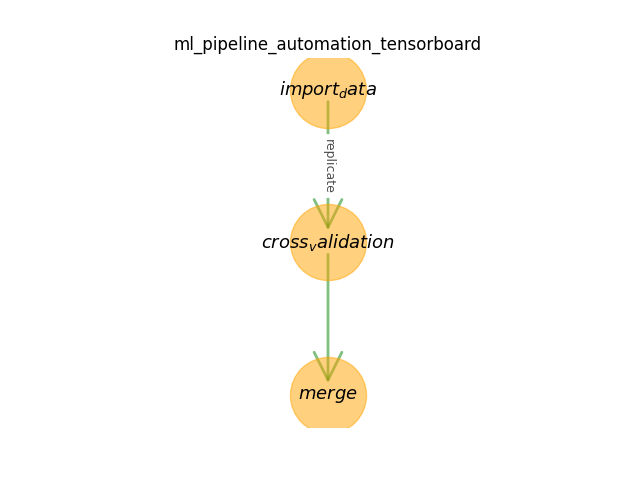

In [8]:
#%draw_job()

### 6. Submitting the job to the scheduler

To submit the job to the ProActive Scheduler, the user has to use the `#%submit_job()` pragma:

```python
#%submit_job()
```

If the job is not created, or is not up-to-date, the `#%submit_job()` creates a new job named as the old one.
To provide a new name, use the same pragma and provide a name as parameter:

```python
#%submit_job([name=JOB_NAME])
```

If the job's name is not set, the ProActive kernel uses the current notebook name, if possible, or gives a random one.

In [9]:
#%submit_job(name=ML_Pipeline_Tensorboard_Example)

Checking REPLICATE controls validity ...
Validated.
Creating a proactive job ...
Job 'ML_Pipeline_Tensorboard_Example' created.
Adding the created tasks to 'ML_Pipeline_Tensorboard_Example' ...
Done.
Submitting the job to the proactive scheduler ...
job_id: 1


### 7. Getting results and outputs

After the execution of a ProActive workflow, two outputs can be obtained,
* results: values that have been saved in the 
[task result variable](https://doc.activeeon.com/latest/user/ProActiveUserGuide.html#_task_result),
* console outputs: classic outputs that have been displayed/printed 

To get task results, please use the `#%get_task_result()` pragma by providing the task name, and either the job ID or
the job name:

```python
#%get_task_result([job_id=JOB_ID], [job_name=JOB_NAME], task_name=TASK_NAME)
```

The result(s) of all the tasks of a job can be obtained with the `#%get_job_result()` pragma, by providing the job name
or the job ID:

```python
#%get_job_result([job_id=JOB_ID], [job_name=JOB_NAME])
```

To get and display console outputs of a task, you can use the `#%print_task_output()` pragma in the following
way:

```python
#%print_task_output([job_id=JOB_ID], [job_name=JOB_NAME], task_name=TASK_NAME)
```

Finally, the  `#%print_job_output()` pragma allows to print all job outputs, by providing the job name or the job ID:

```python
#%print_job_output([job_id=JOB_ID], [job_name=JOB_NAME])
```

NOTE: If neither `job_name` nor the `job_id` are provided, the last submitted job is selected by default. 

In [10]:
#%print_job_output

Getting job 1 console outputs ...
Outputs:


trial 0 average of 0.662115 with std. dev. of 0.041612.
trial 1 average of 0.666821 with std. dev. of 0.045118.
trial 2 average of 0.666681 with std. dev. of 0.049221.
global average 0.665205

